<a href="https://colab.research.google.com/github/ronitd2002/QROSS-GCN-project/blob/main/trial-notebooks/QROSS_Naive-Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# basic libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, Dataset

### Importing and normalizing the data

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# upload training data
from google.colab import files

uploaded_1 = files.upload()

In [ ]:
import os

graphs = {}
index = 0

for filename, file_data in uploaded_1.items():
    file_content = file_data.decode('utf-8')

    start_collecting = False
    coordinates = []

    for line in file_content.splitlines():
        if "NODE_COORD_SECTION" in line:
            start_collecting = True
            continue

        if "EOF" in line or line.strip() == '':
            break

        if start_collecting:
            parts = line.split()
            if len(parts) >= 3:
                # Append [x, y] coordinates (ignore the first column)
                coordinates.append([float(parts[1]), float(parts[2])])

    graphs[index] = coordinates
    index += 1

In [ ]:
for graph in graphs:
    print(f"Instance: {graph}\nCoordinates: {graphs[graph]}\n")
    break

Instance: 0
Coordinates: [[190.90116849279775, 590.4280175750611], [166.92708168528983, 530.2271396316246], [1085.991923849472, 16.922422544709608], [481.1400572117718, 1646.5622569153477], [13.17437595135608, 29.384015131643572], [579.5977925840228, 183.09074463391653], [3152.535909779576, 469.4891656526584], [56.79395127865876, 335.7676041800954], [140.16984710530528, 1415.9907047276663], [298.4056652503395, 432.6438567934434], [1329.4159078188572, 398.07979715224917], [184.34432775505695, 310.6223243278328], [1413.9458436791929, 71.70924057019577], [229.8380192520161, 12.507313429062522], [119.85732963663749, 267.10190426680424], [1068.128373699216, 72.16722331618915], [4.4735957948030896, 260.74107597220853], [315.9927811661698, 453.1032177042161], [74.37417532866615, 462.03510416808166], [391.5463212784245, 568.466736501489], [20.04917685531651, 200.4640408371322], [230.93189213865705, 1251.8991123066855], [1572.7308604790571, 269.1672960446028], [592.4233980658983, 398.9286635813

In [ ]:
print(f"Euclidean coordinates of the 35th graph instance are:")
graphs[35]

Euclidean coordinates of the 35th graph instance are:


[[7207.304443622209, 7324.167128487795],
 [4163.142976744452, 433.4999525698357],
 [2490.932722533464, 4875.366088798042],
 [4551.5205625801955, 2982.122152631126],
 [6763.789886532631, 1030.9891543093809],
 [1192.5835434616927, 6609.37024934381],
 [4233.957584681043, 4034.951770206021],
 [2636.353709072561, 6386.539680951245],
 [5349.1546667631965, 9770.2454151319],
 [5350.938714803364, 7417.2756867157395],
 [3603.702035972396, 966.7842507669433],
 [8336.904519630016, 1307.823731512655],
 [2250.7038620979292, 6451.865150099256],
 [9410.524952419511, 6731.366335870505],
 [8976.457769795643, 8503.88983386449],
 [1713.7074001514418, 1096.4539677469254],
 [2822.1366695079887, 5066.67013828053],
 [3449.0565250305203, 9008.22163939093],
 [7599.90158431922, 6101.292179054742],
 [6282.968640320806, 5723.651901213904],
 [5377.336280017825, 658.9912628221895],
 [5782.466661739941, 3623.846327413507],
 [2612.0291245340845, 6706.035485758186],
 [7905.677924103369, 723.4527207413255],
 [8687.76013

In [ ]:
print(f"We have {len(graphs)} graphs each having {len(graphs[0])} [x,y] coordinate points")

We have 85 graphs each having 30 [x,y] coordinate points


In [ ]:
# upload training data
from google.colab import files

uploaded_2 = files.upload()

In [ ]:
import csv
import io

runs = {}
index = 0

for filename, file_data in uploaded_2.items():
    file_content = file_data.decode('utf-8')

    instance_data = []
    csv_reader = csv.reader(io.StringIO(file_content))

    next(csv_reader, None)

    for row in csv_reader:
        relaxation_param = float(row[0])
        p_f = float(row[1])
        e_std = float(row[2])
        e_avg = float(row[3])
        e_min = float(row[4])

        instance_data.append([relaxation_param, p_f, e_std, e_avg, e_min])

    runs[index] = instance_data
    index+=1

In [ ]:
print(f"Now we have all the information. \nThe runs list contains information about {len(runs)} graphs. \nEach of which is tested for {len(runs[0])} different relaxation parameters. \nFor each such parameter we have a vector of length {len(runs[0][0])} information containing the values of the energies as [A, p_f, e_std, e_avg, e_min] extracted from the annealing experiment")

Now we have all the information. 
The runs list contains information about 85 graphs. 
Each of which is tested for 100 different relaxation parameters. 
For each such parameter we have a vector of length 5 information containing the values of the energies as [A, p_f, e_std, e_avg, e_min] extracted from the annealing experiment


`data[i][j] = [relaxation_parameter, p_f, e_std, e_avg, e_min]` for the $j^{th}$ run of the $i^{th}$ instance

In [ ]:
runs[0][0]

[1952.0, 0.046875, 19742.68658959116, 1589.5882639783756, 16002.903095621281]

## Normalization

Now the instance coordinates are all normalized as per the formula $x^j_i (norm) = (x^j_i - \mu^j)/ \sigma^j$ where $i$ denotes the $i^{th}$ coordinate and $j$ denotes the $j^{th}$ graph instance indexed from 0 -> 84.

In [ ]:
import numpy as np

normed_graphs = {}

for index, coordinates in graphs.items():
    if isinstance(coordinates, list) and all(isinstance(coord, list) and len(coord) == 2 for coord in coordinates):
        x_coords = [coord[0] for coord in coordinates]
        y_coords = [coord[1] for coord in coordinates]

        mean_x = np.mean(x_coords)
        stddev_x = np.std(x_coords)
        mean_y = np.mean(y_coords)
        stddev_y = np.std(y_coords)

        # Normalize formula
        normalized_coords = [
            [(x - mean_x) / stddev_x, (y - mean_y) / stddev_y] for x, y in coordinates
        ]

        normed_graphs[index] = normalized_coords
    else:
        print(f"Skipping instance {filename}: Invalid data format")

In [ ]:
ith_run= np.random.randint(100)
ith_run

97

In [ ]:
x = [coord[0] for coord in normed_graphs[ith_run]]
y = [coord[1] for coord in normed_graphs[ith_run]]
plt.scatter(x,y)
plt.show()

KeyError: 97

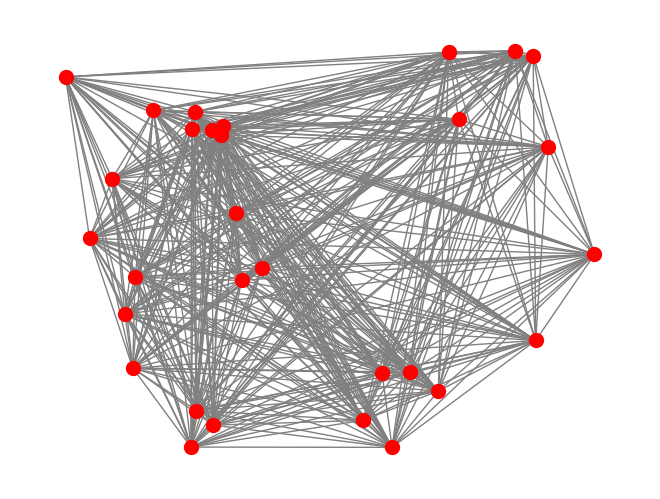

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.Graph()
positions = {i: (x[i], y[i]) for i in range(len(x))}
G.add_nodes_from(positions.keys())
edges = [(i, j) for i in range(len(x)) for j in range(i + 1, len(x))]
G.add_edges_from(edges)
#plt.figure(figsize=(4, 4))
nx.draw(G, pos=positions, node_color='red', node_size=100, edge_color='gray')
plt.show()

In [ ]:
for index in normed_graphs:
  normed_graphs[index] = np.array(normed_graphs[index]).flatten()

In [ ]:
len(normed_graphs[0]), normed_graphs[0]

(60,
 array([-0.53957575,  0.4398966 , -0.57636841,  0.28891542,  0.83410605,
        -0.99843048, -0.09415066,  3.08863531, -0.81233028, -0.96717734,
         0.05695089, -0.58168756,  4.00559883,  0.13658722, -0.745388  ,
        -0.19878064, -0.61743232,  2.51037189, -0.37459028,  0.04418079,
         1.20768504, -0.04250437, -0.54963843, -0.2618439 ,  1.33741181,
        -0.86102752, -0.47981997, -1.00950338, -0.64860562, -0.37099122,
         0.80669114, -0.85987892, -0.82568323, -0.3869439 , -0.3475996 ,
         0.09549198, -0.7184079 ,  0.11789276, -0.23164877,  0.38481866,
        -0.80177963, -0.53811608, -0.47814122,  2.09883731,  1.5810967 ,
        -0.36581131,  0.07663415, -0.04037545, -0.41677442, -0.76171185,
         0.60644975,  0.22005312, -0.25071462, -0.31015826, -0.18220782,
         1.05483859, -0.0163723 , -0.94961733, -0.80539512, -0.97596014]))

In [ ]:
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

# EDA

`data tensor = A[graph_index][data for each relax param]`

`data = [A,pf,estd,eavg,emin]`

In [ ]:
ith_graph = np.random.randint(100)
values = runs[ith_graph]
As = [value[0] for value in values]
pfs = [value[1] for value in values]
estds = [value[2] for value in values]
eavs = [value[3] for value in values]
emins = [value[4] for value in values]
values[1]

KeyError: 90

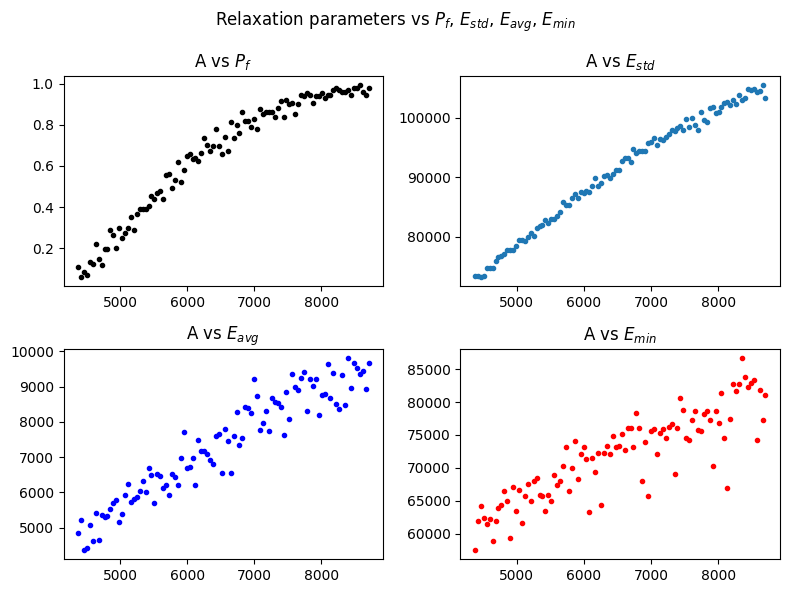

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(8,6))
fig.suptitle('Relaxation parameters vs $P_f$, $E_{std}$, $E_{avg}$, $E_{min}$')

axs[0, 0].set_title("A vs $P_f$")
axs[0, 0].scatter(As, pfs, marker = ".", c = 'k')

axs[0, 1].set_title("A vs $E_{std}$")
axs[0, 1].scatter(As, estds, marker = ".")

axs[1, 0].set_title("A vs $E_{avg}$")
axs[1, 0].scatter(As, eavs, marker = ".", c ='b')

axs[1, 1].set_title("A vs $E_{min}$")
axs[1, 1].scatter(As, emins, marker = ".", c='r')

fig.tight_layout()
fig.savefig('datavis_qross.png')

# Next steps for the project

Our QROSS-based project addresses optimizing relaxation parameters for TSP instances using QUBO formulations and surrogate models. The key challenges include creating usable feature vectors for the neural network and understanding how the training process aligns these vectors with relaxation parameters.

My Plan:

1. **Feature Vector Extraction**:  Use GCNs or similar methods to process graph inputs and produce fixed-size feature vectors. Still have to figure this out. (currently doing so). Hence we build a sort of **FEATURE EXTRACTOR function/class** for each graph **instance**.
2. **Find the min relaxation parameter**: We then assign relaxation parameters from the **data** where P_f is maximized and energy metrics are minimized for training graphs. For this we make a function called a **Min_relaxation_finder**
3. **Train NN based on these min A and the graph feature vectors as the input**:  We then train the model (input → graph feature vector, output → relaxation parameter) using loss functions with `min_relaxation_parameter` as the marker which will use gradient descent etc to backpropagate and thus train our model.
4. **Predict A from test data set for each instance in the test set**: For the test data, we first put them through the FEATURE EXTRACTOR function/class to get the feature vectors of the test graphs annd then retrieve the predicted relaxation parameter for each graph.
5. **Validation**: Now we have the predicted **A**, then we can put the $i^{th}$ graph's data matrix into the min_relaxation_finder function to find the A_min for the particular instance. Then our validation loss shall be (`predicted_A` - `min_A`$)^2$ which should be ideally very very low.

# OPTIMAL A VECTOR for both training and testing data`min_relaxation_param` function

In [ ]:
def min_relaxation_params(data_dict, lambda_1=5.0, lambda_2=1.0):

  optimal_A_dict = {}

  for idx, data_matrix in data_dict.items():
    data_matrix = np.array(data_matrix)
    A_values = data_matrix[:][0]
    P_f = data_matrix[:][1]
    E_avg = data_matrix[:][2]
    E_std = data_matrix[:][3]
    E_min = data_matrix[:][4]

    scores = lambda_1 * P_f - lambda_2 * (E_avg + E_std + E_min)
    best_index = np.argmax(scores)

    optimal_A_dict[idx] = A_values[best_index]

  return optimal_A_dict

In [ ]:
np.asarray(runs[0]).shape, type(runs), len(runs)

((100, 5), dict, 85)

In [ ]:
min_relaxations = min_relaxation_params(runs)
type(min_relaxations)

dict

In [ ]:
min_relaxations

{0: 19742.68658959116,
 1: 11624.152000070813,
 2: 0.0,
 3: 11506.749468451164,
 4: 18246.745018940368,
 5: 16491.04149047193,
 6: 20442.571485561864,
 7: 17426.207328027966,
 8: 0.0,
 9: 10185.40627015858,
 10: 7717.078702199341,
 11: 15790.34150683544,
 12: 18567.23992090268,
 13: 16704.28466084302,
 14: 18894.239826881414,
 15: 68537.17944943796,
 16: 73729.92762407339,
 17: 71523.61410078392,
 18: 76842.98970748132,
 19: 72229.4909184825,
 20: 77300.68921104146,
 21: 82534.79916936645,
 22: 74228.41565754259,
 23: 76991.24839892563,
 24: 75592.60232978663,
 25: 73988.25920308115,
 26: 78787.26530533658,
 27: 87120.74921811942,
 28: 72684.38739915902,
 29: 69358.95123947253,
 30: 80719.279308477,
 31: 83935.9135087967,
 32: 77628.33783257734,
 33: 82361.63150910153,
 34: 73356.46366435052,
 35: 66520.56738166166,
 36: 76001.08928002197,
 37: 75178.56972050073,
 38: 77326.43231809612,
 39: 76866.22702002636,
 40: 77928.8618546301,
 41: 75801.35170391705,
 42: 73890.14344464957,
 43: 

# Graph FEATURE VECTOR EXTRACTOR

In [ ]:
print(f"We have {len(graphs)} graphs which have {len(graphs[0])} nodes each with {len(graphs[0][0])} coordinates.")

We have 85 graphs which have 30 nodes each with 2 coordinates.


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, global_mean_pool

num_graphs = len(graphs)
num_nodes = len(graphs[0])
input_dim = len(graphs[0][0])

In [ ]:
def compute_adjacency(coords):
    num_nodes = coords.shape[0]
    adjacency_matrix = np.zeros((num_nodes, num_nodes))
    for i in range(num_nodes):
        for j in range(num_nodes):
            adjacency_matrix[i, j] = np.sqrt((coords[i, 0] - coords[j, 0])**2 + (coords[i, 1] - coords[j, 1])**2)
    return adjacency_matrix

In [ ]:
graph_data_list = []
for i in range(num_graphs):
    coords = graphs[i]
    adjacency_matrix = compute_adjacency(np.array(coords))

    edge_index = np.array(np.nonzero(adjacency_matrix)).astype(np.int64)
    edge_weight = adjacency_matrix[edge_index[0], edge_index[1]]

    # Convert to PyTorch tensors
    edge_index = torch.tensor(edge_index, dtype=torch.long)
    edge_weight = torch.tensor(edge_weight, dtype=torch.float32)
    node_features = torch.tensor(coords, dtype=torch.float32)

    # Create graph data object
    data = Data(x=node_features, edge_index=edge_index, edge_attr=edge_weight)
    graph_data_list.append(data)

In [ ]:
print(f"We got graph data list for each {len(graph_data_list)} graphs in the samples we took for experiment of the graph pooling")

We got graph data list for each 85 graphs in the samples we took for experiment of the graph pooling


In [ ]:
class GraphFeatureExtractor(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GraphFeatureExtractor, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = global_mean_pool(x, torch.zeros(x.size(0), dtype=torch.long))  # Graph-level pooling
        x = self.fc(x)
        return x

In [ ]:
#initialize the Graph convolutional neural network
hidden_dim = 64 # neurons in hidden layer
output_dim = 128 # dimension of the graph feature vector
model = GraphFeatureExtractor(input_dim, hidden_dim, output_dim) # instantiate the model

graph_tensor = graph_data_list[0]
graph_feature_vector = model(graph_tensor)

In [ ]:
# Batch processing for multiple graphs
from torch_geometric.loader import DataLoader

loader = DataLoader(graph_data_list, batch_size=2, shuffle=True)
batch_graph_features_vector = []
for batch in loader:
    batch_graph_features = model(batch)  # Batch graph-level features
    batch_graph_features_vector.append(batch_graph_features)

In [ ]:
len(batch_graph_features_vector[0][0])

128

# Big mistake do not simply encode the graphs! Train them to yield good predictions.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv
import random

class GraphFeatureExtractor(nn.Module): # this is our beautiful training model
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GraphFeatureExtractor, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)
        self.global_pool = nn.AdaptiveAvgPool1d(1)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu() # using relu activation
        x = self.conv2(x, edge_index).relu()
        return x.mean(dim=0) # global feture vector for the graph

In [ ]:
def generate_edge_index(num_nodes):
    edge_index = []
    for i in range(num_nodes):
        for j in range(num_nodes):
            if i != j:
                edge_index.append([i, j])
    return torch.tensor(edge_index, dtype=torch.long).t().contiguous() # just necessary form for the pytorch geometric library for edge representation

def prepare_dataset(graphs_dict, optimal_A):
    dataset = []
    for idx, coords in graphs_dict.items():
        x = torch.tensor(coords, dtype=torch.float32) # input as graph
        edge_index = generate_edge_index(x.shape[0]) # generates the edge indices
        y = torch.tensor([optimal_A[idx]], dtype=torch.float32) # output as the relaxation parameter upon which the model shall be trained.
        data = Data(x=x, edge_index=edge_index, y=y) # get the data in pytorch geometric format basically instructing the full format of our model
        dataset.append(data)
    return dataset

In [ ]:
dataset = prepare_dataset(graphs,min_relaxations)
len(dataset), type(dataset[0]).x, type(dataset[0]).y, type(dataset[0]).edge_index

(85,
 <property at 0x78955939d3a0>)

In [ ]:
def split_data(graphs, optimal_A, split_ratio=0.8):
    indices = list(graphs.keys()) # get keys
    random.shuffle(indices) # shuffle the indices list
    split = int(len(indices) * split_ratio) # split wrt split ratio
    train_indices = indices[:split] # get training graph indices
    test_indices = indices[split:] # get testing graph indices

    train_graphs = {i: graphs[i] for i in train_indices}
    train_A = {i: optimal_A[i] for i in train_indices}

    test_graphs = {i: graphs[i] for i in test_indices}
    test_A = {i: optimal_A[i] for i in test_indices}

    return train_graphs, train_A, test_graphs, test_A

In [ ]:
train_graphs, train_A, test_graphs, test_A = split_data(graphs,min_relaxations)

list(test_graphs.keys()) == list(test_A.keys()) # just checking

True

In [ ]:
def train_model(model, train_loader, optimizer, lossfunc):
    model.train()
    total_loss = 0
    for data in train_loader:
        optimizer.zero_grad()
        out = model(data.x, data.edge_index)
        loss = lossfunc(out.squeeze(), data.y) # loss function
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

In [ ]:
def validate_model(model, test_loader, lossfunc):
    model.eval()  # Set model to evaluation mode
    total_loss = 0
    predicted = []
    actual = []

    with torch.no_grad():  # Disable gradient calculations for validation
        for data in test_loader:
            # Move data to GPU
            data = data.to(device)

            # Model predictions
            out = model(data.x, data.edge_index)  # Shape: (batch_size, 1)

            # Ensure target (data.y) is on the GPU
            target = data.y.to(device)  # Shape: (batch_size, 1)

            # Reshape to ensure consistency
            out = out.view(-1)  # Flatten to shape: (batch_size,)
            target = target.view(-1)  # Flatten to shape: (batch_size,)

            # Compute loss
            loss = lossfunc(out, target)
            total_loss += loss.item()

            # Store predictions and actuals
            predicted.extend(out.cpu().numpy())  # Append all predictions in the batch
            actual.extend(target.cpu().numpy())  # Append all targets in the batch

    avg_loss = total_loss / len(test_loader)  # Compute average validation loss
    return avg_loss, predicted, actual

In [ ]:
train_dataset = prepare_dataset(train_graphs, train_A)
test_dataset = prepare_dataset(test_graphs, test_A)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

In [ ]:
input_dim = 2 # 2 coordinates
hidden_dim = 16 # 16 hidden neurons (can be tested for other values)
output_dim = 1 # relaxation parameter for each graph input
model = GraphFeatureExtractor(input_dim, hidden_dim, output_dim) # our beautiful model
lossfunc = nn.MSELoss() # standard mse loss
optimizer = optim.Adam(model.parameters(), lr=0.01) # adam optimizer for optimization


######################## CHECK MODEL CONSISTENCY WITH THE DEVICE -> SINCE WE ARE USING COLAB CUDA T4 GPU #################################################################
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model, device

(GraphFeatureExtractor(
   (conv1): GCNConv(2, 16)
   (conv2): GCNConv(16, 1)
   (global_pool): AdaptiveAvgPool1d(output_size=1)
 ),
 device(type='cuda', index=0))

In [ ]:
import torch
print(torch.cuda.is_available())  # Should return True
print(torch.cuda.get_device_name(0))  # Should print "T4"

True
Tesla T4


In [ ]:
train_loader = [data.to(device) for data in train_loader]
test_loader = [data.to(device) for data in test_loader]

In [ ]:
train_losses =[]
val_losses =[]
epochs = 200


for epoch in range(epochs):

    train_loss = train_model(model, train_loader, optimizer, lossfunc)
    train_losses.append(train_loss)

    val_loss, predicted, actual = validate_model(model, test_loader, lossfunc)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/200, Train Loss: 2669129258.6667, Val Loss: 3069853717.3333
Epoch 2/200, Train Loss: 2588551879.1111, Val Loss: 2944331733.3333
Epoch 3/200, Train Loss: 2515752647.1111, Val Loss: 2798502656.0000
Epoch 4/200, Train Loss: 2425906915.5556, Val Loss: 2616824917.3333
Epoch 5/200, Train Loss: 2315683299.5556, Val Loss: 2400567594.6667
Epoch 6/200, Train Loss: 2186607843.5556, Val Loss: 2155040576.0000
Epoch 7/200, Train Loss: 2042528227.5556, Val Loss: 1889402538.6667
Epoch 8/200, Train Loss: 1889393905.7778, Val Loss: 1615943018.6667
Epoch 9/200, Train Loss: 1734733710.2222, Val Loss: 1348863680.0000
Epoch 10/200, Train Loss: 1586848682.6667, Val Loss: 1102590784.0000
Epoch 11/200, Train Loss: 1453747029.3333, Val Loss: 889726570.6667
Epoch 12/200, Train Loss: 1341924238.2222, Val Loss: 718937205.3333
Epoch 13/200, Train Loss: 1255204999.1111, Val Loss: 593298634.6667
Epoch 14/200, Train Loss: 1193998677.3333, Val Loss: 509790528.0000
Epoch 15/200, Train Loss: 1155351352.8889, Val 

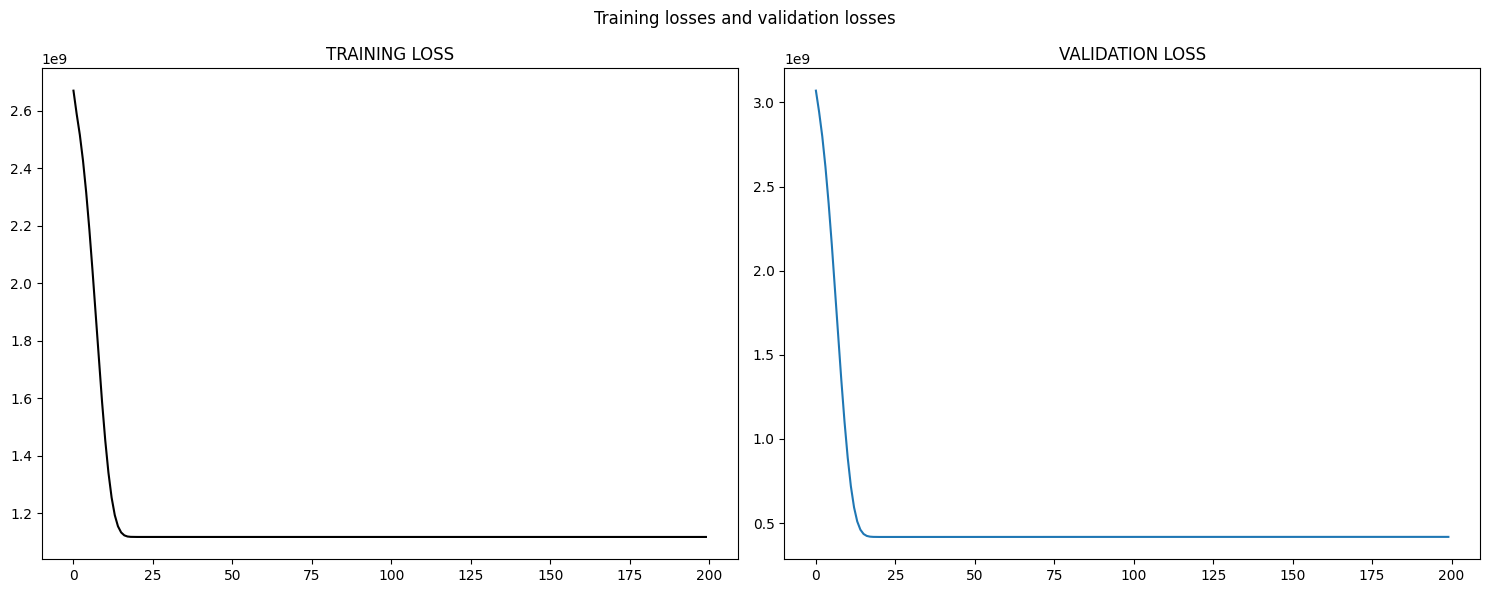

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(15,6))
fig.suptitle('Training losses and validation losses')

axs[0].set_title("TRAINING LOSS")
axs[0].plot(train_losses, c = "k", ls="-")

axs[1].set_title("VALIDATION LOSS")
axs[1].plot(val_losses, ls="-")

fig.tight_layout()

In [ ]:
validation_vector = [(pred - act) ** 2 for pred, act in zip(predicted, actual)]
print(f"Validation Vector: {validation_vector}")

Validation Vector: [274527359.87701416, 17436635.2348032, 1027974.1994628906]
